# 13.12 风格迁移
- **目录**
  - 13.12.1 风格迁移方法
  - 13.12.2 读取内容与风格图像
  - 13.12.3 风格迁移预处理和后处理
  - 13.12.4 抽取图像特征
  - 13.12.5 定义风格迁移损失函数
    - 13.12.5.1 内容损失
    - 13.12.5.2 风格损失
    - 13.12.5.3 全变分损失
    - 13.12.5.4 损失函数
  - 13.12.6 初始化合成图像
  - 13.12.7 训练风格迁移模型

- 如果你是一位摄影爱好者，你也许接触过滤波器。它能改变照片的颜色风格，从而使风景照更加锐利或者令人像更加美白。
  - 但一个**滤波器**通常只能改变照片的某个方面。
  - 如果要照片达到理想中的风格，你可能需要尝试大量不同的**组合**。
  - 这个过程的复杂程度不亚于模型调参。
- 在本节中，我们将介绍如何使用卷积神经网络，**自动**将一个图像中的风格应用在另一图像之上，即<b>风格迁移（style transfer） </b>。
  - 首先需要两张输入图像：一张是**内容图像**，另一张是**风格图像**。
  - 将使用神经网络修改内容图像，使其在风格上接近风格图像。
- 例如图13.12.1中的内容图像为本书作者在西雅图郊区的雷尼尔山国家公园拍摄的风景照，而风格图像则是一幅主题为秋天橡树的油画。
  - 最终输出的合成图像应用了风格图像的油画笔触让整体颜色更加鲜艳，同时保留了内容图像中物体主体的形状。

<center><img src='../img/style-transfer.svg'></center>
<center>图13.12.1 输入内容图像和风格图像，输出风格迁移后的合成图像</center>

- **要点：**
  - 摄影中使用滤波器可以改变照片的颜色风格，但通常需要组合多个滤波器达到理想效果。
  - 风格迁移使用卷积神经网络自动将一张图像的风格应用到另一张图上。
  - 需要两张图：内容图像和风格图像。
  - 网络调整内容图像，使其风格趋近于风格图像。
  - 结果是合成图像，融合了风格图案及内容图形状。

- 本节包含函数列表：
  - preprocess： 图像标准化和尺寸调整
  - postprocess：还原图像像素值并裁剪到[0,1]范围
  - extract_features：抽取指定层的内容和风格特征
  - get_contents：提取内容图像的特征
  - get_styles：提取风格图像的特征
  - content_loss：计算内容损失（平方误差）
  - gram：计算Gram矩阵（风格相关性）
  - style_loss：计算风格损失（Gram矩阵差异）
  - tv_loss：计算全变分损失（减少噪点）
  - compute_loss：汇总内容、风格和全变分损失
  - SynthesizedImage：合成图像模型（参数为像素值）
  - get_inits：初始化合成图像和优化器
  - train：训练循环，更新合成图像  

## 13.12.1 风格迁移方法

- 图13.12.2用简单的例子阐述了基于卷积神经网络的风格迁移方法。 
  - 首先初始化合成图像，例如将其初始化为内容图像。 
    - 该**合成图像是风格迁移过程中唯一需要更新的变量，即风格迁移所需迭代的模型参数**。
  - 然后，我们选择一个预训练的卷积神经网络来抽取图像的特征，其中的模型参数在训练中**无须更新**。
    - 这个深度卷积神经网络凭借多个层逐级抽取图像的特征，我们可以选择其中**某些层的输出作为内容特征或风格特征**。 
    - 以 图13.12.2为例，这里选取的预训练的神经网络含有3个卷积层，其中第二层输出内容特征，第一层和第三层输出风格特征。
<center><img src='../img/neural-style.svg'></center>
<center>图13.12.2 基于卷积神经网络的风格迁移。实线箭头和虚线箭头分别表示前向传播和反向传播</center>

  - 接下来，通过前向传播（实线箭头方向）计算风格迁移的损失函数，并通过反向传播（虚线箭头方向）迭代模型参数，即不断更新合成图像。
  - 风格迁移常用的损失函数由3部分组成：
    - （i）**内容损失**使合成图像与内容图像在内容特征上接近；
    - （ii）**风格损失**使合成图像与风格图像在风格特征上接近；
    - （iii）**全变分损失**则有助于减少合成图像中的噪点。
  - 最后，当模型训练结束时，我们输出风格迁移的**模型参数**，即得到最终的合成图像。
<br>
- **要点：**
  - 风格迁移使用预训练的卷积神经网络抽取特征。
  - 合成图像以内容图像初始化并作为唯一需要迭代更新的变量。
  - 选取网络中不同层输出作为内容特征和风格特征。
  - 通过前向传播计算损失函数，反向传播更新合成图像。
  - 损失函数包括内容损失、风格损失和全变分损失。
  - 训练结束后输出模型参数得到最终的合成图像。


- 在下面通过代码来进一步了解风格迁移的技术细节。

## 13.12.2 读取内容与风格图像
- 首先读取内容和风格图像。
  - 从打印出的图像坐标轴可以看出，它们的尺寸并不一样。

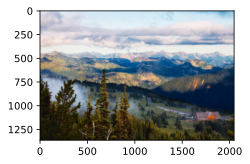

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import warnings
warnings.filterwarnings("ignore")

d2l.set_figsize()
content_img = d2l.Image.open('../img/rainier.jpg')
d2l.plt.imshow(content_img);

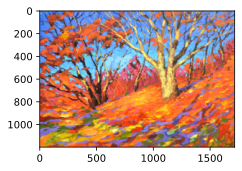

In [2]:
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

## 13.12.3 风格迁移预处理和后处理
- 下面，定义图像的预处理函数和后处理函数。
  - 预处理函数`preprocess`对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。
  - 后处理函数`postprocess`则将输出图像中的像素值**还原**回标准化之前的值。
- 由于图像打印函数要求每个像素的浮点数值在0到1之间，此处对小于0和大于1的值分别取0和1。


In [3]:
## 原代码
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

- preprocess与postprocess详细注释

In [4]:
## 代码详细注释
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])


def preprocess(img, image_shape):
    '''
    （1）将改变图像的形状至image_shape。
    （2）将PIL图像或numpy.ndarray转换为torch.Tensor。转换后的图像的数据范围是[0, 1]。
    （3）将图像通道进行标准化，即减去均值后再除以标准差。
    '''
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    '''
    图像经过定义的变换后，
    使用unsqueeze(0)增加一个批处理维度，
    使其形状从[channels, height, width]变为[1, channels, height, width]。
    '''
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    '''
    （1）首先使用permute(1, 2, 0)将tensor的形状从[channels, height, width]变为[height, width, channels]，
    （2）然后进行逆标准化操作（乘以标准差并加上均值）。
    （3）torch.clamp确保tensor中的值范围在[0, 1]内。
    '''
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    '''
    （1）首先再次使用permute将图像数据的形状从[height, width, channels]变为[channels, height, width]。
    （2）然后将tensor转换回PIL图像。
    '''
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [5]:
## 示例：
image_shape = (300, 450)
pre = preprocess(content_img,image_shape)
pre.shape

torch.Size([1, 3, 300, 450])

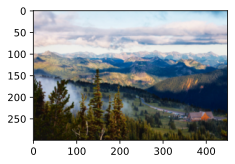

In [6]:
import matplotlib.pyplot as plt
post = postprocess(pre)
plt.imshow(post);

-----------
- **说明：**
- **（1）为何要将tensor的形状从[channels, height, width]变为[height, width, channels]，然后进行逆标准化操作？**
  - 当使用深度学习框架（例如PyTorch）处理图像数据时，习惯采用<b>\[channels, height, width\]</b>的形式，称为**CHW格式**。这种格式适合深度学习操作，如卷积，因为框架可以高效地处理通道维度。
  - 然而传统的图像处理库和函数，如PIL或matplotlib，通常期望图像数据的形状为<b>\[height, width, channels\]</b>，即**HWC格式**。这是因为这种格式更符合人类的直觉和传统的图像处理方法。
  - 在`postprocess`函数中，为什么要先将形状从CHW变为HWC再进行逆标准化操作呢？
    - 这主要是为了方便和效率。当我们对整个图像进行逆标准化操作（即乘以标准差和加上均值）时，HWC格式更直观。
    - 这是因为标准差和均值是针对每个通道的，所以如果使用CHW格式，需要沿通道轴进行广播。
    - 而在HWC格式中，对于每个像素位置，只需要使用与其对应的通道的均值和标准差来进行操作，这在编写和理解代码时更为直观。
  - 总之，CHW格式更适合深度学习操作，但HWC格式在某些传统的图像处理任务中更为直观和方便。因此，在进行逆标准化并将数据传递给这些图像处理库之前，通常会先将数据转换为HWC格式。
<br><br>
- **（2）何为PIL图像？与matplotlib有何关联？**
  - PIL（Python Imaging Library）是一个用于图像处理的流行Python库。后来，该库由于不再维护，所以被另一个名为Pillow的项目继承。在很多现代的Python环境中，当提到"PIL"，实际上是指的Pillow，但由于历史原因，经常继续使用"PIL"这个名字。
  - **PIL的主要特点如下**：
    - 1. 提供了基本的图像处理功能，如打开图像、裁剪、旋转、调整大小等。
    - 2. 支持各种图像格式，如JPEG、PNG、BMP、GIF等。
    - 3. 提供了一些简单的图像分析工具，例如直方图生成等。
    - 4. 可以与NumPy配合使用，这意味着图像数据可以轻松地转换为数组，反之亦然。
  - **matplotlib**是一个用于绘图的Python库，可以生成各种静态、动态、交互式的图表。尽管matplotlib不是专门为图像处理设计的，但它包含一些用于显示和处理图像的功能。
  - **PIL和matplotlib的联系**：
    - 1. **图像显示**：虽然PIL有自己的图像显示方法，但很多人更喜欢使用matplotlib来显示图像，因为matplotlib提供了更多的控制和功能。
    - 2. **数据转换**：当你使用PIL加载图像时，图像数据存储为PIL的Image对象。为了在matplotlib中显示或进行数值计算，通常需要将这个Image对象转换为一个NumPy数组。反之，如果有一个NumPy数组并想用PIL的某些特定功能来处理它，则需要首先将它转换为一个PIL Image对象。
    - 3. **颜色空间**：matplotlib和PIL都可以处理不同的颜色空间，如RGB、RGBA、L（灰度）等。
  - 总之，尽管PIL和matplotlib有自己的专长领域，但它们在图像处理和分析的工作流中经常一起使用。
    - PIL主要负责基本的图像处理任务
    - matplotlib主要负责显示和绘制图形。
------------

## 13.12.4 抽取图像特征

- 使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征。


In [7]:
## 原代码
pretrained_net = torchvision.models.vgg19(weights=True)

## 由于上述代码会将权重文件下载到c盘，因此改用如下代码更加灵活
#pretrained_net = torchvision.models.vgg19(pretrained=False)  # 不从默认源下载权重
## 注意将torch.load函数的参数修改成vgg19权重文件在本机上的保存位置！！
#pretrained_net.load_state_dict(torch.load('../weights/vgg19-dcbb9e9d.pth'))

------------
- **说明：torchvision.models.vgg19函数返回的VGG19结构**
  - 在PyTorch中，`VGG19`和其他`VGG`模型都是通过`torchvision.models.vgg.VGG`类来实现的。
    - `VGG`类的对象主要由两个子模块组成：`features`和`classifier`。
  - 1. **features模块**:
    这是VGG模型的主要部分，负责执行大多数的卷积操作。这部分与上述VGG19模型的卷积部分对应。
    - **卷积层和池化层**:
        对于VGG19, features模块具有以下结构:
        - 2个卷积层（每个层都有64个3x3的滤波器），然后是一个最大池化层。
        - 2个卷积层（每个层都有128个3x3的滤波器），然后是一个最大池化层。
        - 4个卷积层（每个层都有256个3x3的滤波器），然后是一个最大池化层。
        - 4个卷积层（每个层都有512个3x3的滤波器），然后是一个最大池化层。
        - 4个卷积层（每个层都有512个3x3的滤波器），然后是一个最大池化层。
    - 对应于我们之前的描述，`features`模块将输入图像通过这些层进行转换，生成一组特征映射。
  - 2. **classifier模块**:
    这是VGG模型的尾部，由三个全连接层组成。与上述VGG19模型的全连接部分相对应。
    - 对于VGG19，`classifier`模块有以下结构:
        - 一个包含4096个神经元的全连接层，接着是ReLU激活函数和Dropout层。
        - 另一个包含4096个神经元的全连接层，接着是ReLU激活函数和Dropout层。
        - 一个包含1000个神经元的全连接输出层（对应于ImageNet数据集的1000个类别）。
  - 当你调用`torchvision.models.vgg19`函数时，你会得到一个`VGG`对象，这个对象已经按照VGG19的结构进行了初始化。
  - 可以通过`vgg.features`和`vgg.classifier`来访问相应的模块。
------------

In [8]:
## pretrained_net是orchvision.models.vgg.VGG类的对象
## VGG类是torch.nn.Module的子类
type(pretrained_net)

torchvision.models.vgg.VGG

In [9]:
## VGG对象包含了features、avgpool和classifier三个组件
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

--------------

- 为了抽取图像的内容特征和风格特征，可以选择VGG网络中某些层的输出。
  - 一般来说，**越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息**。
- 为了避免合成图像过多保留内容图像的细节，可选择VGG较靠近输出的层，即**内容层**，来输出图像的内容特征。
- 还从VGG中选择不同层的输出来匹配局部和全局的风格，这些图层也称为**风格层**。
- 正如 7.2节中所介绍的，VGG网络使用了5个卷积块。
- 实验中，选择第四卷积块的**最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为风格层**。
  - 这些层的索引可以通过打印`pretrained_net`实例获取。


In [10]:
## 分别获取pretrained_net的不同层
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

- 使用VGG层抽取特征时， 此处只需要用到从输入层到最靠近输出层的内容层或风格层之间的所有层。
- 下面构建一个新的网络`net`，它只保留需要用到的VGG的所有层。


In [11]:
## 获取VGG模型对象pretrained_net的features组件中的前29层
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [12]:
## net获取了VGG的前29层
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

- 给定输入`X`，如果简单地调用前向传播`net(X)`，只能获得最后一层的输出。
- 由于还需要中间层的输出，因此这里**可逐层计算**，并保留内容层和风格层的输出。


In [13]:
'''
从指定的层提取内容和风格特征，
两种信息可以用于后续的风格迁移算法。
content_layers, style_layers已经在前面定义。
注意后面在抽取内容层与风格层时，输入的X分别是内容图像与风格图像。
本函数的功能是获得内容与风格的特征图
'''
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        # 抽取VGG模型风格层的输出特征图
        if i in style_layers:
            styles.append(X)
        # 抽取VGG模型内容层的输出特征图
        if i in content_layers:
            contents.append(X)
    return contents, styles

- 下面定义两个函数：
  - `get_contents`函数对内容图像抽取内容特征；
  - `get_styles`函数对风格图像抽取风格特征。
- 因为在训练时无须改变预训练的VGG的模型参数，所以可以**在训练开始之前**就提取出内容特征和风格特征。
- 由于合成图像是风格迁移所需迭代的模型参数，此处只能在训练过程中通过调用`extract_features`函数来抽取合成图像的内容特征和风格特征。


In [14]:
'''
image_shape是输入内容图像的大小。
然后进行预处理，即减去通道均值后的差除以标准差。
然后根据内容图像从模型中间层抽取内容标签特征。
preprocess函数参数content_img是前文中读取的图像。
preprocess对读取的图像进行标准化处理。
contents_Y与styles_Y一次性提取之后作为固定值不再变化，
然后作为损失函数的计算目标，作用类似图像分类中的类别标签。
然后每个训练周期，模型会调用extract_features函数获得contents_Y_hat, styles_Y_hat，
将contents_Y_hat、 styles_Y_hat与contents_Y、styles_Y分别一起计算内容损失和风格损失，
最后在进行权重更新。
注意后面风格损失计算使用Gram矩阵(格拉姆矩阵)。
'''
def get_contents(image_shape, device):
    '''
    content_X对内容图像进行预处理(形状缩放,标准化)后的结果。
    在训练阶段时作为合成图像的初始化依据。
    '''
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    '''
    style_X后期基本上没用上。
    styles_Y的Gram矩阵作为模型训练的标签使用。
    '''
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [15]:
device = torch.device('cpu')
## 内容特征的细节信息
content_X, contents_Y = get_contents(image_shape, device)
content_X.shape,contents_Y[0].shape,len(contents_Y)

(torch.Size([1, 3, 300, 450]), torch.Size([1, 512, 37, 56]), 1)

In [16]:
## 风格特征的细节信息
style_X, styles_Y = get_styles(image_shape, device)
style_X.shape, styles_Y[0].shape, styles_Y[1].shape,styles_Y[2].shape,styles_Y[3].shape,styles_Y[4].shape,len(styles_Y)

(torch.Size([1, 3, 300, 450]),
 torch.Size([1, 64, 300, 450]),
 torch.Size([1, 128, 150, 225]),
 torch.Size([1, 256, 75, 112]),
 torch.Size([1, 512, 37, 56]),
 torch.Size([1, 512, 18, 28]),
 5)

In [17]:
## 后面训练过程在抽取特征时，使用content_X作为extract_features的第一个参数
contents_Y_hat, styles_Y_hat = extract_features(content_X, content_layers, style_layers)
contents_Y_hat[0].shape,styles_Y_hat[0].shape

(torch.Size([1, 512, 37, 56]), torch.Size([1, 64, 300, 450]))

## 13.12.5 定义风格迁移损失函数

- 下面描述风格迁移的损失函数。
  - 它由**内容损失**、**风格损失**和**全变分损失**3部分组成。

### 13.12.5.1 内容损失
- 与线性回归中的损失函数类似，内容损失通过**平方误差函数**衡量合成图像与内容图像在内容特征上的差异。
- 平方误差函数的两个输入**均为**`extract_features`函数计算所得到的内容层的输出。


In [18]:
'''
将contents_Y_hat作为Y_hat参数的值是每个训练周期内调用extract_features获得。
而contents_Y作为Y参数的值则是在训练开始前调用get_contents获得的，且调用前需对原始输入进行预处理。
'''
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

In [19]:
content_loss(contents_Y_hat[0], contents_Y[0].detach())

tensor(0., grad_fn=<MeanBackward0>)

------------
- **说明：为何说“这是一个规定的值，而不是一个变量”?**
  - 上述代码定义了一个称为`content_loss`的函数，它计算两个输入张量`Y_hat`和`Y`之间的均方误差。
  -  在函数内部，有这样的语句：`Y.detach()`。
     - 这里的`.detach()`方法创建了一个新的张量，该张量从原始张量`Y`中获得数据，但不参与原始张量的计算图。
     - 换句话说，该张量不会在反向传播中计算梯度。
  - 这里所说的"这是一个规定的值，而不是一个变量。"的意思是，通过使用`detach()`，我们明确地告诉PyTorch，我们不希望`Y`在反向传播中更新。
    - 它只是一个固定的目标值或参考值，不应该被视为一个可训练的变量。
    - 我们只对`Y_hat`进行优化（例如，在风格迁移中调整输入图像），而不对`Y`进行优化。
  - 这在风格迁移中很有用：当计算内容损失时，其目标是使生成的图像（例如`Y_hat`）尽可能地接近原始内容图像（例如`Y`），但不希望原始内容图像本身发生变化，所以将其从梯度计算中分离出来。
----------

### 13.12.5.2 风格损失
- 风格损失与内容损失类似，也通过**平方误差函数**衡量合成图像与风格图像在风格上的差异。
- 为了表达风格层输出的风格，可先通过`extract_features`函数计算风格层的输出。
- 假设该输出的样本数为1，通道数为$c$，高和宽分别为$h$和$w$，可以将此输出转换为矩阵$\mathbf{X}$，其有$c$行和$hw$列。
  - 这个矩阵可以被看作是由$c$个长度为$hw$的向量$\mathbf{x}_1, \ldots, \mathbf{x}_c$组合而成的。其中**向量$\mathbf{x}_i$代表了通道$i$上的风格特征**。
- 在这些向量的<b>格拉姆矩阵</b>$\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$中，$i$行$j$列的元素$x_{ij}$即向量$\mathbf{x}_i$和$\mathbf{x}_j$的内积。
  - 该内积表达了通道$i$和通道$j$上风格特征的相关性。
- 此处用这样的格拉姆矩阵来表达风格层输出的风格。
  - 需要注意的是，当$hw$的值较大时，格拉姆矩阵中的元素容易出现**较大的值**。
  - 此外，格拉姆矩阵的高和宽皆为通道数$c$。
- 为了让风格损失不受这些值的大小影响，下面定义的`gram`函数将格拉姆矩阵**除以了矩阵中元素的个数**，即$chw$。


In [20]:
## 输入参数X的形状(batch_size, num_channels, height, width)
def gram(X):
    ## 通道数和每个通道的元素个数
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    ## 将X变形为(通道数，每通道元素个数)，便于计算格拉姆矩阵
    X = X.reshape((num_channels, n))
    ## 计算格拉姆矩阵，并除以矩阵的元素总数对矩阵进行规范化
    return torch.matmul(X, X.T) / (num_channels * n)

In [21]:
## 注意styles_Y是一个保存了5个风格特征的list
## 下例举一个风格特征张量作为gram的输入
gram(styles_Y[0]).shape

torch.Size([64, 64])

- 风格损失的平方误差函数的两个格拉姆矩阵输入分别**基于合成图像与风格图像的风格层输出**，这也是自然之事。
- 这里假设基于风格图像的格拉姆矩阵`gram_Y`已经预先计算好了。


In [22]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [23]:
## 风格损失函数示例
style_loss(styles_Y_hat[0], gram(styles_Y[0]))

tensor(2.1560e-05, grad_fn=<MeanBackward0>)

-----------
- **说明：风格损失以及格拉姆矩阵的通俗解释**
  - 风格损失是风格迁移中的一个关键概念。下面我将为你提供一种通俗的解释。
  - 想象你正在看两幅画。一幅是梵高的《星夜》，另一幅是达芬奇的《蒙娜丽莎》。
    - 这两幅画在"风格"上有很大的不同。<br>    
    <img src='../img/13_1.jpg'>     <img src='../img/13_2.jpg'>
  - 但什么是“风格”呢？从计算的角度来看，风格可以被认为是图像中**不同层次特征间的关系或交互**。
    - 例如，梵高的画可能在颜色和纹理上有强烈的旋涡模式，而达芬奇的画则更加细腻平滑。
  - 可以使用"格拉姆矩阵"来从数学角度描述这种关系。
    - 首先需要将图片通过神经网络（例如VGG网络）进行处理，从而得到其在不同层次的特征表示。
      - 特定层的输出可以看作是一个三维数据，包括宽、高和通道（每个通道都是该层的一个特定特征）。
    - 接下来，计算每个通道与其他通道之间的关系，这就是我们所说的格拉姆矩阵。
      - 简单地说，格拉姆矩阵描述了图片中的各种风格特征是如何互相关联的。
      - 例如，一个通道可能表示“蓝色”，另一个通道可能表示“旋涡模式”，那么这两个通道之间的关系值会告诉我们这幅画中蓝色旋涡模式的强度。
    - 然后，为了让风格损失不受图片尺寸的影响，会对格拉姆矩阵进行规范化，这样无论处理的是大图还是小图，风格损失都是有意义的。
    - **风格损失本身就是比较合成图像与风格参考图像的格拉姆矩阵之间的差异**。
      - 这种差异告诉我们合成图像在风格上与参考风格图像有多远离。

------------

### 13.12.5.3 全变分损失

- 有时候学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。
- 一种常见的去噪方法是<b>全变分去噪（total variation denoising）</b>，其目的是抑制高频噪声，提升合成图像的视觉平滑性。
- 假设$x_{i, j}$表示坐标$(i, j)$处的像素值，降低全变分损失
$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right| \tag{13.12.1}$$
  能够尽可能使邻近的像素值相似。


In [24]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [25]:
## 使用内容特征计算全变分损失
## 原本应该是合成图像的权重或像素(同一个东西)作为参数输入的
tv_loss(contents_Y_hat[0])

tensor(0.1873, grad_fn=<MulBackward0>)

---------
- **说明：**
- **（1）tv_loss函数的具体涵义**
  - `tv_loss` 函数计算的是图像所有相邻像素在**垂直和水平方向上差异的平均值的一半**。通过最小化这个损失，模型学习创造出在像素值方面变化更平滑的图像，从而可能减少图像中的噪声和提高视觉质量。这个损失经常与其他损失函数组合使用，以便根据具体任务调节图像的平滑程度。
  -  `Y_hat` 是合成图像张量，通常在深度学习中，经过卷积神经网络处理的图像可能具有多个维度，比如 `[batch size, channels, height, width]`。
  -  `Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]`: 这部分代码计算图像在垂直方向上相邻像素之间的差异。`Y_hat[:, :, 1:, :]` 表示图像从第二行到最后一行的所有像素；`Y_hat[:, :, :-1, :]` 表示图像从第一行到倒数第二行的所有像素。这两部分相减，就得到了所有垂直相邻像素之间的差。
  -  `Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]`: 这部分代码计算图像在水平方向上相邻像素之间的差异。`Y_hat[:, :, :, 1:]` 表示图像从第二列到最后一列的所有像素；`Y_hat[:, :, :, :-1]` 表示图像从第一列到倒数第二列的所有像素。这两部分相减，就得到了所有水平相邻像素之间的差。
  -  `torch.abs(...)`: 计算绝对值，以确保损失是非负的。
  -   `mean()`: 取平均值，计算得到的差异值的平均数，这表示所有像素差异的平均情况。
  -   由于前面差的绝对值的均值被乘上了`0.5`，这意味着结果被缩减了一半。这一步通常是可选的，可能是为了调整损失函数的规模。




- **（2）全变分损失公式13.12.1为何使用L1范数？和L2范数有何区别？**
  - 全变分损失使用L1范数能够有效地降低图像噪声水平，特别是针对高频噪点，同时保留图像的重要结构和细节。这种去噪方法在处理某些类型的噪声和图像内容时，能够实现一种平衡，减少过度平滑的风险，从而保留更多细节：
    - **稀疏性引导**：L1范数倾向于产生稀疏性，这在图像去噪中意味着它会推动邻近像素之间的差异趋向于零。这种稀疏性引导有助于去掉图像中的噪点，特别是那些孤立的高频噪点，而保留较大的、有意义的结构差异。L1范数因此能更有效地平滑图像，同时避免过度模糊边缘等重要特征。
    - **弱平滑假设**：L1范数通过促使图像邻近像素值相似，实际上是在应用一种弱平滑假设——即图像中相邻区域应当在颜色和亮度上保持一致性，而不是强制所有区域都有相同的像素值。这有助于维持图像的基本结构和边缘信息，因为L1范数对那些较大的像素差异（即边缘）不会那么敏感。
    - **鲁棒性**：L1范数对于异常值（如极亮或极暗的像素点）具有较好的鲁棒性。在累加邻近像素之间的绝对差值时，这些异常值不会对总的差异值贡献过大影响，这样就可以平滑小的高频噪声，同时保留重要的图像特征，如边缘和纹理。
    - **计算上的简洁性**：L1范数是绝对值的线性组合，这种计算比L2范数（平方和的开方）在数学处理上更简单，尤其是在进行优化时。这使得基于L1范数的全变分去噪方法在某些情况下更易于实现和求解。
  - L2范数（平方和的开方）的全变分（TV）损失是在众多TV模型中的一个常见的选择，通常在数学和图像处理文献中称为**二次全变分（quadratic TV）** ：
    - **平滑性**：L2范数会对图像进行较为平滑的处理，由于它对大的值给予更大的权重（由于平方的性质），所以它在减少噪点的同时可能也会对图像的细节进行平滑。
    - **数值稳定性**：L2范数由于其连续和可导的性质，在数值方法和优化算法中可能会更容易处理。对于某些优化问题，L2范数可以保证解的存在性和唯一性，并允许使用如梯度下降法等标准优化方法来求解。
    - **计算梯度**：L2范数的一个优点是其梯度计算相对简单直接。在梯度下降算法中，使用L2范数可以容易地计算出梯度并更新图像。
  - L1和L2范数的权衡：
    - 使用L1范数的全变分损失比L2范数更适合边缘保持。它通常在去噪时**更能保留图像的边缘和纹理细节**，而不会被平滑过头。
    - L1范数也被广泛用于图像去噪中，因为它倾向于产生“块状”效果，这在某些情况下可以更接近自然图像中的边缘特征。
    - 在不同的去噪方法和应用上，选择L1还是L2范数作为全变分项，取决于希望图像的平滑程度、保留细节的需求、数值优化方法的便利性等因素。
    - 有些情况下，为了在边缘保存和噪声去除之间找到最佳平衡，甚至可以使用L1和L2混合范数。
  


------------

### 13.12.5.4 损失函数

- **风格转移的损失函数是内容损失、风格损失和总变分损失的加权和**。
- 通过调节这些权重超参数，我们可以权衡合成图像在保留内容、迁移风格以及去噪三方面的相对重要性。


In [26]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    ## styles_l复制10遍，然后一起求和，本质是将styles_l再乘以权重10
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## 13.12.6 初始化合成图像
- 在风格迁移中，合成的图像是训练期间**唯一需要更新的变量**。
- 因此可以定义一个简单的模型`SynthesizedImage`，并将合成的图像视为模型参数。
- 模型的前向传播只需返回模型参数即可。


In [27]:
'''
合成图像类用来进行前向传播和模型训练，
唯一需要更新的参数就是作为模型权重的合成图像像素。
前向传播函数forward函数返回权重(像素)值。
'''
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

- 下面定义`get_inits`函数。该函数创建了合成图像的模型实例，并将其初始化为图像`X`。
- 风格图像在各个风格层的格拉姆矩阵`styles_Y_gram`将在训练前预先计算好。


In [28]:
'''
X形状(300, 450)，这是一个统一的形状参数。
X.data后面代码中将看到是使用内容图像经过预处理后的值拷贝给合成图像的权重数据的。
styles_Y_gram在本函数中预先通过调用gram函数计算好，作为风格损失的标签，
此处是一个含有5个张量元素的list。
'''
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## 13.12.7 训练风格迁移模型
- 在训练模型进行风格迁移时，不断抽取合成图像的内容特征和风格特征，然后计算损失函数。
- 下面定义了训练循环。


In [29]:
## train函数原代码
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

- train详细注释代码

In [30]:
'''
模型训练时输入X的参数值是content_X，即内容图像经过预处理后的张量。
然后依次是内容特征，风格特征，设备，学习率，训练周期数，学习率衰减率等参数。
'''
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    '''
    初始化合成图像、计算风格gram矩阵，设置优化器
    初始化合成图像X中的权重或像素是模型训练时参数更新的对象。
    '''
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)    
    '''
    （1）torch.optim.lr_scheduler.StepLR是PyTorch提供的一个学习率调度器，
        它会根据设定的步长(lr_decay_epoch)来调整优化器的学习率，用于根据步长来调整学习率。
         每经过设定的步长，学习率会乘以一个给定的因子。
    （2）trainer: 这是模型的优化器，通常使用`torch.optim`中的某个优化算法，如SGD、Adam等。
    （3）lr_decay_epoch: 这是学习率调度器的步长。
         每经过`lr_decay_epoch`个周期（epoch），学习率会乘以后面给定的因子（本例中是0.8）。
    （4）0.8: 这是学习率的衰减因子。当每个lr_decay_epoch周期结束时，当前学习率会乘以这个因子，从而实现学习率的衰减。
        在这段代码中，训练过程每经过lr_decay_epoch个周期，学习率就会乘以0.8，
        这样的衰减策略有助于模型在初期快速接近最优解，
        然后在接近最优解时通过降低学习率来细化模型的调整，防止在最优解附近发生震荡。
    '''
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        ##提取内容和风格特征
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        ## 内容损失、风格损失、总变分损失、全部损失加权和
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward() 
        trainer.step() ##参数更新，其实就是更新X中作为权重参数的像素
        ## 执行学习率的调整
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    
    return X

- 现在训练模型：
  - 首先将内容图像和风格图像的高和宽分别调整为300和450像素，用内容图像来初始化合成图像。


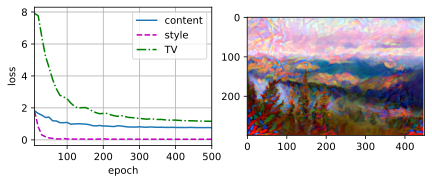

In [31]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

- 可以看到，合成图像保留了内容图像的风景和物体，并同时迁移了风格图像的色彩。
  - 例如，合成图像具有与风格图像中一样的色彩块，其中一些甚至具有画笔笔触的细微纹理。

## 小结

* 风格迁移常用的损失函数由3部分组成：（i）内容损失使合成图像与内容图像在内容特征上接近；（ii）风格损失令合成图像与风格图像在风格特征上接近；（iii）全变分损失则有助于减少合成图像中的噪点。
* 我们可以通过预训练的卷积神经网络来抽取图像的特征，并通过最小化损失函数来不断更新合成图像来作为模型参数。
* 我们使用格拉姆矩阵表达风格层输出的风格。